This is a simple illustration of a [Particle Swarm](https://en.wikipedia.org/wiki/Particle_swarm_optimization) trying to find the minimum of a [Perceptron](https://en.wikipedia.org/wiki/Perceptron). Obviously the code is imperfect, but this should serve as a useful illustration.

Parameters can be set in the "PSO" function in the penultimate cell of this notebook. 

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import itertools
        # some global variables
dim=2;  # There is in principle no problem to use the perceptron in higher dimensions
        # Here, however, you would need to make some adjustments for plotting. 
N=100;  # How many data points do we want? In principle, two are enough, 
        # but you will see better the effect of noise with more data points
        # For this purpose, try to change sigma in GenData() below.
x=[[]*dim]*N;   # These will be the data 
y=[0]*N;        # and these the respective labels  

We first generate some data. They will be shown in the end.

In [2]:
def GenData():
    sigma=0.5;
    for i in range(N):     
        if i%2==0:
            x[i] = np.random.normal(1.0,sigma,2)
            y[i]=1
        else:
            x[i] = np.random.normal(-1.0,sigma,2)
            y[i]=-1

The following will be the goal ("fitness") function. Here it is to be minimised.

In [3]:
def perceptron(pos,data):    #this serves as a goal function
                            # Defined by f(x,y) = (a-x)^2 + b(y-x^2)^2
                            # Using here: a = 1, b= 100, optimum 0 at (1,1)
    error=0;
    for i in range(N):
        perc_out=0;
        for j in range(dim):
            perc_out+=x[i][j]*pos[j]; 
        if (perc_out*y[i]<0):    # sign is different!
            error+=1;
    return error;

In [4]:
class Particle: # all the material that is relavant at the level of the individual particles
    
    def __init__(self, dim, minx, maxx):
        self.position = np.random.uniform(low=minx, high=maxx, size=dim)
        self.velocity = np.random.uniform(low=-0.1, high=0.1, size=dim)
        self.best_particle_pos = self.position
        self.dim = dim

        self.fitness = perceptron(self.position,dim)
        self.best_particle_fitness = self.fitness   # we couldd start with very large number here, 
                                                    #but the actual value is better in case we are lucky 
                
    def setPos(self, pos):
        self.position = pos
        self.fitness = perceptron(self.position,self.dim)
        if self.fitness<self.best_particle_fitness:     # to update the personal best both 
                                                        # position (for velocity update) and
                                                        # fitness (the new standard) are needed
                                                        # global best is update on swarm leven
            self.best_particle_fitness = self.fitness
            self.best_particle_pos = pos

    def updateVel(self, inertia, a1, a2, best_self_pos, best_swarm_pos):
                # Here we use the canonical version
                # V <- inertia*V + a1r1 (peronal_best - current_pos) + a2r2 (global_best - current_pos)
        cur_vel = self.velocity
        r1 = np.random.uniform(low=0, high=1, size = self.dim)
        r2 = np.random.uniform(low=0, high=1, size = self.dim)
        a1r1 = np.multiply(a1, r1)
        a2r2 = np.multiply(a2, r2)
        best_self_dif = np.subtract(best_self_pos, self.position)
        best_swarm_dif = np.subtract(best_swarm_pos, self.position)
                    # the next line is the main equation, namely the velocity update, 
                    # the velocities are added to the positions at swarm level 
        return inertia*cur_vel + np.multiply(a1r1, best_self_dif) + np.multiply(a2r2, best_swarm_dif)


In [5]:
class PSO: # all the material that is relavant at swarm leveel

    def __init__(self, w, a1, a2, dim, population_size, time_steps, search_range):

        # Here we use values that are (somewhat) known to be good
        # There are no "best" parameters (No Free Lunch), so try using different ones
        # There are several papers online which discuss various different tunings of a1 and a2
        # for different types of problems
        self.w = w # Inertia
        self.a1 = a2 # Attraction to personal best
        self.a2 = a2 # Attraction to global best
        self.dim = dim

        self.swarm = [Particle(dim,-search_range,search_range) for i in range(population_size)]
        self.time_steps = time_steps
        #print('init')

        # Initialising global best, you can wait until the end of the first time step
        # but creating a random initial best and fitness which is very high will mean you
        # do not have to write an if statement for the one off case
        self.best_swarm_pos = np.random.uniform(low=-500, high=500, size=dim)
        self.best_swarm_fitness = 1e100

    def run(self):
        for t in range(self.time_steps):
            for p in range(len(self.swarm)):
                particle = self.swarm[p]

                new_position = particle.position + particle.updateVel(self.w, self.a1, self.a2, particle.best_particle_pos, self.best_swarm_pos)
                                
                if new_position@new_position > 1.0e+18: # The search will be terminated if the distance 
                                                        # of any particle from center is too large
                    print('Time:', t,'Best Pos:',self.best_swarm_pos,'Best Fit:',self.best_swarm_fitness)
                    raise SystemExit('Most likely divergent: Decrease parameter values')
 
                self.swarm[p].setPos(new_position)

                new_fitness = perceptron(new_position,self.dim)

                if new_fitness < self.best_swarm_fitness:   # to update the global best both 
                                                            # position (for velocity update) and
                                                            # fitness (the new group norm) are needed
                    self.best_swarm_fitness = new_fitness
                    self.best_swarm_pos = new_position
          #
          #  if t % 100 == 0: #we print only two components even it search space is high-dimensional
          #      print("Time: %6d,  Best Fitness: %14.6f,  Best Pos: %9.4f,%9.4f" % (t,self.best_swarm_fitness,self.best_swarm_pos[0],self.best_swarm_pos[1]), end =" ")
          #      if self.dim>2: 
          #          print('...')
          #      else:
          #          print('')
        return(self.best_swarm_pos);

Standard values are dim=2, w=0.7, a1=2.02, a2=2.02, population_size=30; but feel free to try others ones.

In [6]:
GenData();
res=PSO(dim=2, w=0.7, a1=2.02, a2=2.02, population_size=30, time_steps=101, search_range=1).run()
res

array([441.93690904, 121.45026562])

PSO has now produced a result which we are going to plot together with the data.

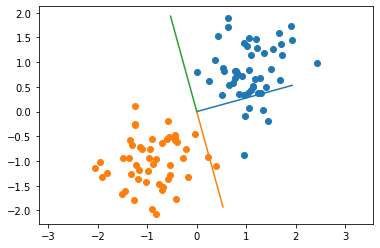

In [7]:
GenData();
plt.axis('equal')
z=np.transpose(x[::2])
plt.scatter(z[0],z[1])
z=np.transpose(x[1::2])
plt.scatter(z[0],z[1])
norm=np.sqrt(res[0]*res[0]+res[1]*res[1])*0.5 # just a arbitrary scaling factor
plt.plot([0,res[0]/norm],[0,res[1]/norm]);  # This is the vector found by the PSO. 
                                            # It should point towards the blue data subset.
                                            # It may not be perfect. How can you improve the result?
plt.plot([0,res[1]/norm],[0,-res[0]/norm]); # these are two orthogonal vectors that represent the separation plane. 
plt.plot([0,-res[1]/norm],[0,res[0]/norm]);
plt.show()